In [1]:
%matplotlib inline
import sys
sys.path.insert(0, 'src')

import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/paulw/Downloads/graphviz-9.0.0-win32/Graphviz/bin'
os.environ["PATH"] += os.pathsep + './Graphviz/bin'

I remember struggling with getting Graphviz to work. It needed to be installed globally, but the anaconda install didn't want to do that?

In [2]:
import stlcg
import stlviz as viz
from stlcg import Expression
from utils import print_learning_progress
import graphviz

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd

In [4]:
import re
from datetime import datetime
import pytz
import timeit

## Create traces from numpy arrays

- Fake discrete events
- Day of week

### Loading the data and preprocessing

In [5]:
#data = pd.read_csv(r"C:\Users\paulw\Downloads\co2_dump151018\co2_dump151018 (3).csv", header=None)
data = pd.read_csv(r"./data/co2_dump151018.csv", header=None)

C:\Users\paulw\AppData\Local\Temp\ipykernel_7976\1125946964.py:2: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"./data/co2_dump151018.csv", header=None)


In [6]:
data.shape

(6116516, 7)

In [7]:
#data[np.logical_not(data[0].str.isnumeric())]
# There are some entries which have faulty values -> remove those
# I took a look at the raw data, and if the first column (id) is blank (not a number), there certainly is something wrong
data = data[np.logical_not(np.logical_not(data[0].str.isnumeric()))]
data.shape

(6115961, 7)

In [8]:
data.head()

,0,1,2,3,4,5,6
0,4678229,1.533243e+09,2944.0,30.5,61.0,89,9.0
1,6642641,1.533365e+09,2779063733.0,27.3,0.0,667,73.0
2,8267680,1.533200e+09,347.0,-100.0,63.8,24,0.0
3,8267681,1.533200e+09,287.0,27.6,63.8,25,0.0
4,8267682,1.533200e+09,296.0,27.6,63.8,24,0.0


We can already see that the data has some faulty values.  
Additionally, most columns are read as objects and not as numbers/floats, due to some measurement errors

In [9]:
#data.iloc[:,1].astype('Int64')

In [10]:
data.iloc[:,2]

0                2944.0
1          2779063733.0
2                 347.0
3                 287.0
4                 296.0
               ...     
6116511           244.0
6116512           244.0
6116513           246.0
6116514           246.0
6116515           246.0
Name: 2, Length: 6115961, dtype: object

In [11]:
bm = data.iloc[:,2].astype(str).str.contains(r'^[\d]+.[\d]+$', regex=True)

In [12]:
data[np.logical_not(bm)]

,0,1,2,3,4,5,6
2305,NaN,1.0,NaN,NaN,NaN,NaN,NaN
15987,NaN,0.0,NaN,NaN,NaN,NaN,NaN
16591,NaN,1.0,NaN,NaN,NaN,NaN,NaN
19280,NaN,0.0,NaN,NaN,NaN,NaN,NaN
24236,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6057333,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6058431,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6085835,NaN,9.0,NaN,NaN,NaN,NaN,NaN
6106973,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [13]:
data2 = data[bm]
data2.shape

(6096745, 7)

In [14]:
data2.iloc[:,2] = data2[2].apply(lambda f: float(str(f).replace("..", ".")))

In [15]:
#data2[4].astype('float32')
data2.iloc[:,3] = data2[3].apply(lambda f: float(str(f).replace("e+","")))
data2.iloc[:,4] = data2[4].apply(lambda f: float(str(f).replace("e+","")))

In [16]:
data2 = data2[np.logical_not(data2[6].isna())]

In [17]:
bm5 = (data2.iloc[:,5].apply(lambda f: (re.fullmatch(r'^([\d]*.?[\d]*)$', str(f))))).astype(bool)
# I'm checking if the values start and with numbers, with potentially a dot inbetween (as they are floats)
# then I'm casting all of that to boolean to use it as indexing later
# For whatever reason python here makes some funky business when dealing with \ in the string. I cannot figure out why, seriously, so I'm giving up on that

In [18]:
data3 = data2[bm5]

In [19]:
data3.iloc[:,1].astype(int)

0          1533243314
1          1533365453
2          1533199750
3          1533199751
4          1533199752
              ...    
6116511    1539576830
6116512    1539576830
6116513    1539576833
6116514    1539576833
6116515    1539576833
Name: 1, Length: 6096127, dtype: int32

In [20]:
data = data3.astype("float32")

In [21]:
data[1] = data3.iloc[:,1].astype('Int64')

In [22]:
data.head()

,0,1,2,3,4,5,6
0,4678229.0,1533243314,2.944000e+03,30.500000,61.000000,89.0,9.0
1,6642641.0,1533365453,2.779064e+09,27.299999,0.000000,667.0,73.0
2,8267680.0,1533199750,3.470000e+02,-100.000000,63.799999,24.0,0.0
3,8267681.0,1533199751,2.870000e+02,27.600000,63.799999,25.0,0.0
4,8267682.0,1533199752,2.960000e+02,27.600000,63.799999,24.0,0.0


In [23]:
data.describe()

,0,1,2,3,4,5,6
count,6.096127e+06,6096127.0,6.096127e+06,6.096127e+06,6.096127e+06,6.096127e+06,6.096127e+06
mean,1.133138e+07,1536425967.0187,6.528586e+06,6.753611e+04,1.074762e+05,8.348641e+05,3.011100e+00
std,1.786186e+06,1886215.720998,1.119857e+10,4.114151e+07,7.084035e+07,8.493925e+08,3.838815e+00
min,4.678229e+06,1533199750.0,0.000000e+00,-1.000000e+02,-2.800576e+06,0.000000e+00,0.000000e+00
25%,9.793242e+06,1534736317.5,1.400000e+02,2.640000e+01,5.300000e+01,3.000000e+01,0.000000e+00
50%,1.133606e+07,1536543770.0,2.020000e+02,2.830000e+01,6.410000e+01,1.390000e+02,1.000000e+00
75%,1.286194e+07,1537908442.0,2.630000e+02,3.170000e+01,7.240000e+01,5.640000e+02,9.000000e+00
max,1.439004e+07,1539576834.0,2.725154e+13,3.953952e+10,7.153707e+10,1.351536e+12,7.300000e+01


There are MASSIVE outliers for essentially all columns. Those could be measurement errors or problems in storing the values.  
Either way we need to take a look at them

In [24]:
iqrco2 = (data[2].quantile(.75)-data[2].quantile(.25))
iqrtemp = (data[3].quantile(.75)-data[3].quantile(.25))

In [25]:
#data[2].quantile(.25)-1.5*iqrco2
#data[2].quantile(.75)+1.5*iqrco2

In [26]:
#data[data[2]>= (data[2].quantile(.75)+1.5*iqrco2)][2]
#data[2].sort_values(ascending=False)[0:20]

In [27]:
data.sort_values(by=0, inplace=True)
data.drop(index=[0,1,2], inplace=True)

In [28]:
# Remove outliers in temperature with Inter Quartile Range -> There are a lot of measurement errors that are denoted with -100. These could be replace with the Average of the last observations, but that's effort.
# Then there's also a lot of readings above 50 degrees. In the article they mention most common range is 25-30°, and sometimes above 35. A quick google search says the average max temp is around 35° in Indonesia.
# The measurements are taken somewhere along a road at 1m height, so I just doubt it goes above 50° that often (sometimes high 70s and above)
data = data[(data[3]< (data[3].quantile(.75)+1.5*iqrtemp)) & (data[3]> (data[3].quantile(.25)-1.5*iqrtemp))]

In [29]:
# As the humidity is a percentage, it cannot be negative or above 1, so I remove all of those entries as well.
data = data[(data[4]>0) & ((data[4]<=100))]

In [30]:
data = data[data[2]<2500]
# There are 10 values which exceed the threshhold for essentially immediate issues in exposure

There are faulty readings in the data. For simplicity, I removed them.

## Data Description

According to the Article:
- Column 0: Is a Record ID, which is simply incremented
- Column 1: Linux timestamp -> We can use this to also convert a time dimension
- Column 2: The CO2 concentration in parts per million. It should realistically not exceed 1000ppm, which is considered "good", and above 30k is possible but rare -> limited exposure of 15min See more here:https://www.health.state.mn.us/communities/environment/air/toxins/co2.html
- Column 3: Temperature in Degree Celsius - Should not exceed -50 to +50, and realistically is between 25 to 32
- Column 4: Humidity in Percent -> betwen 0 and 100
- Column 5: Light Intensity should be between 0 - 1000

- Check performance of one constraint on various time horizons
- Boolean signals as "discrete" states of the system

In [31]:
data

,0,1,2,3,4,5,6
3,8267681.0,1533199751,287.0,27.600000,63.799999,25.0,0.0
4,8267682.0,1533199752,296.0,27.600000,63.799999,24.0,0.0
5,8267683.0,1533199753,301.0,27.600000,63.799999,24.0,0.0
6,8267684.0,1533199754,297.0,27.600000,63.799999,23.0,0.0
7,8267685.0,1533199755,315.0,27.700001,63.900002,23.0,0.0
...,...,...,...,...,...,...,...
6116511,14390026.0,1539576830,244.0,27.000000,65.500000,574.0,1.0
6116512,14390027.0,1539576830,244.0,27.000000,65.500000,574.0,1.0
6116513,14390035.0,1539576833,246.0,27.000000,65.500000,138.0,1.0
6116514,14390036.0,1539576833,246.0,27.000000,65.500000,138.0,1.0


In [32]:
#n = 60*60*24*30
n = 60*60

In [33]:
data.sort_values(by=[0,6])

,0,1,2,3,4,5,6
3,8267681.0,1533199751,287.0,27.600000,63.799999,25.0,0.0
4,8267682.0,1533199752,296.0,27.600000,63.799999,24.0,0.0
5,8267683.0,1533199753,301.0,27.600000,63.799999,24.0,0.0
6,8267684.0,1533199754,297.0,27.600000,63.799999,23.0,0.0
7,8267685.0,1533199755,315.0,27.700001,63.900002,23.0,0.0
...,...,...,...,...,...,...,...
6116511,14390026.0,1539576830,244.0,27.000000,65.500000,574.0,1.0
6116512,14390027.0,1539576830,244.0,27.000000,65.500000,574.0,1.0
6116513,14390035.0,1539576833,246.0,27.000000,65.500000,138.0,1.0
6116514,14390036.0,1539576833,246.0,27.000000,65.500000,138.0,1.0


In [34]:
data[data[6] == 0]

,0,1,2,3,4,5,6
3,8267681.0,1533199751,287.0,27.600000,63.799999,25.0,0.0
4,8267682.0,1533199752,296.0,27.600000,63.799999,24.0,0.0
5,8267683.0,1533199753,301.0,27.600000,63.799999,24.0,0.0
6,8267684.0,1533199754,297.0,27.600000,63.799999,23.0,0.0
7,8267685.0,1533199755,315.0,27.700001,63.900002,23.0,0.0
...,...,...,...,...,...,...,...
6116469,14389944.0,1539576830,299.0,26.900000,66.599998,147.0,0.0
6116472,14389947.0,1539576831,310.0,26.900000,66.599998,147.0,0.0
6116474,14389950.0,1539576832,301.0,26.900000,66.599998,146.0,0.0
6116475,14389953.0,1539576833,306.0,26.900000,66.599998,145.0,0.0


In [35]:
#data.iloc[1:5,1].apply(lambda f: datetime.fromtimestamp(f, tz=pytz.timezone("Asia/Jakarta")).strftime("%d-%m-%Y %H:%M:%S"))

In [68]:
#data[7] = data[1].apply(lambda f: datetime.utcfromtimestamp(f).strftime("%d-%m-%Y %H:%M:%S"))
data[7] = data[1].apply(lambda f: datetime.fromtimestamp(f, tz=pytz.timezone("Asia/Jakarta")).strftime("%d-%m-%Y %H:%M:%S"))

In [70]:
data.iloc[:,7] = data.iloc[:,7].apply(lambda f: datetime.strptime(f, "%d-%m-%Y %H:%M:%S"))

In [37]:
data.head()

,0,1,2,3,4,5,6,7
3,8267681.0,1533199751,287.0,27.600000,63.799999,25.0,0.0,02-08-2018 15:49:11
4,8267682.0,1533199752,296.0,27.600000,63.799999,24.0,0.0,02-08-2018 15:49:12
5,8267683.0,1533199753,301.0,27.600000,63.799999,24.0,0.0,02-08-2018 15:49:13
6,8267684.0,1533199754,297.0,27.600000,63.799999,23.0,0.0,02-08-2018 15:49:14
7,8267685.0,1533199755,315.0,27.700001,63.900002,23.0,0.0,02-08-2018 15:49:15


In [38]:
# This gets the index of an element in a list. I use it to iterate over all values
#[0,1,9].index(1)

In [39]:
data.sort_values(1, inplace=True)

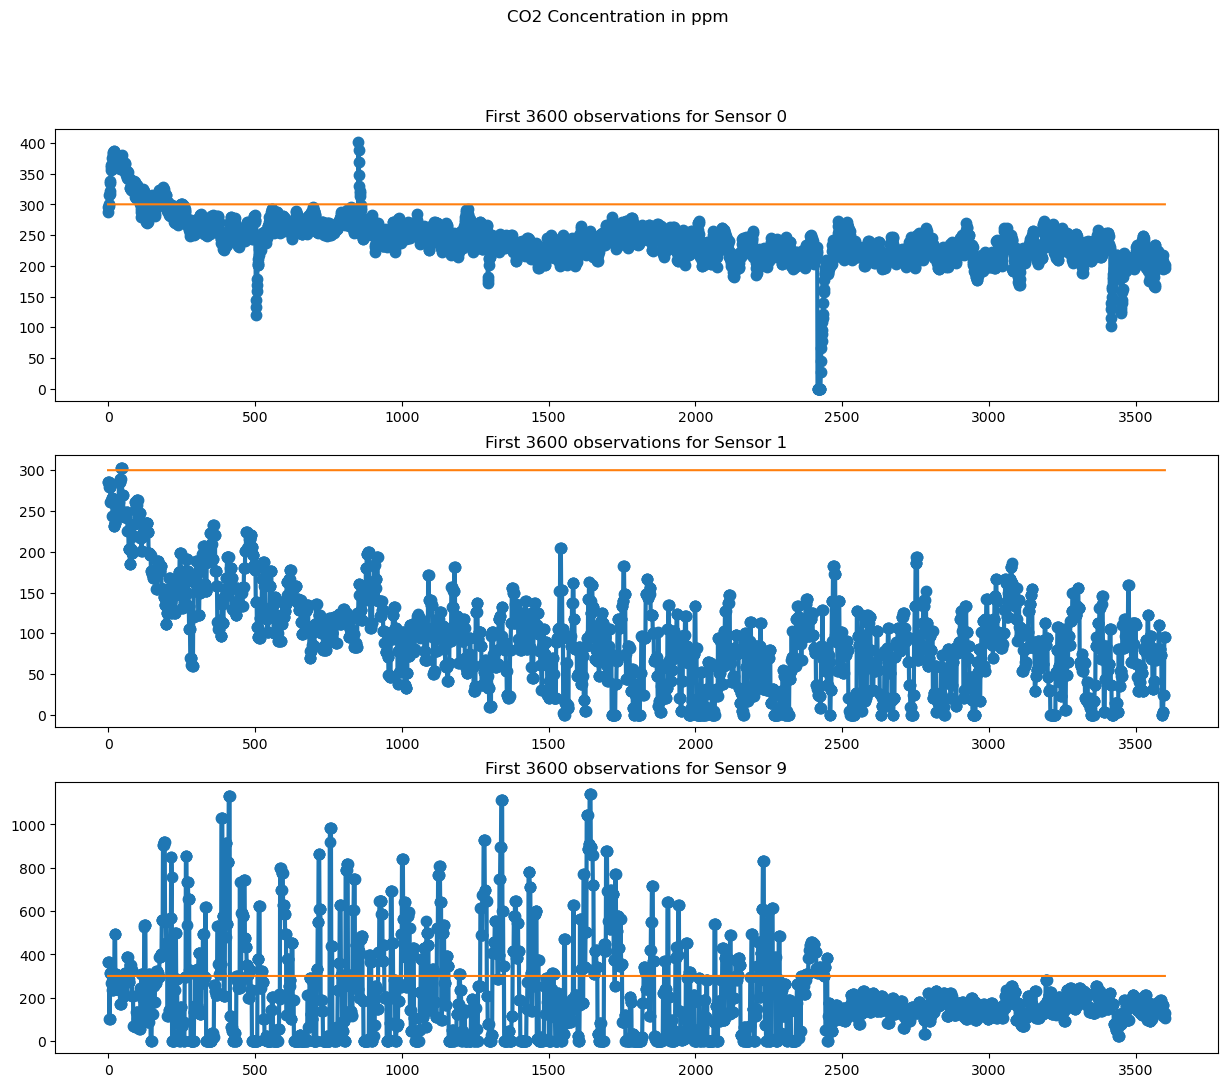

In [40]:
fig, axs_ = plt.subplots(3)
fig.set_figheight(12)
fig.set_figwidth(15)

for k in [0,1,9]:
    axs_[[0,1,9].index(k)].plot(range(n),data[data[6]==k].iloc[0:n,2], ".-", linewidth=3, markersize=15, label="x")
    #plt.plot(range(n), np.full(n,300))
    axs_[[0,1,9].index(k)].plot(range(n), np.full(n,300))
    axs_[[0,1,9].index(k)].set_title(f"First {n} observations for Sensor {k}")
    

#plt.title("CO2 Concentration")
fig.suptitle("CO2 Concentration in ppm")
#plt.savefig("./plots/co2ppm.png")
plt.show()

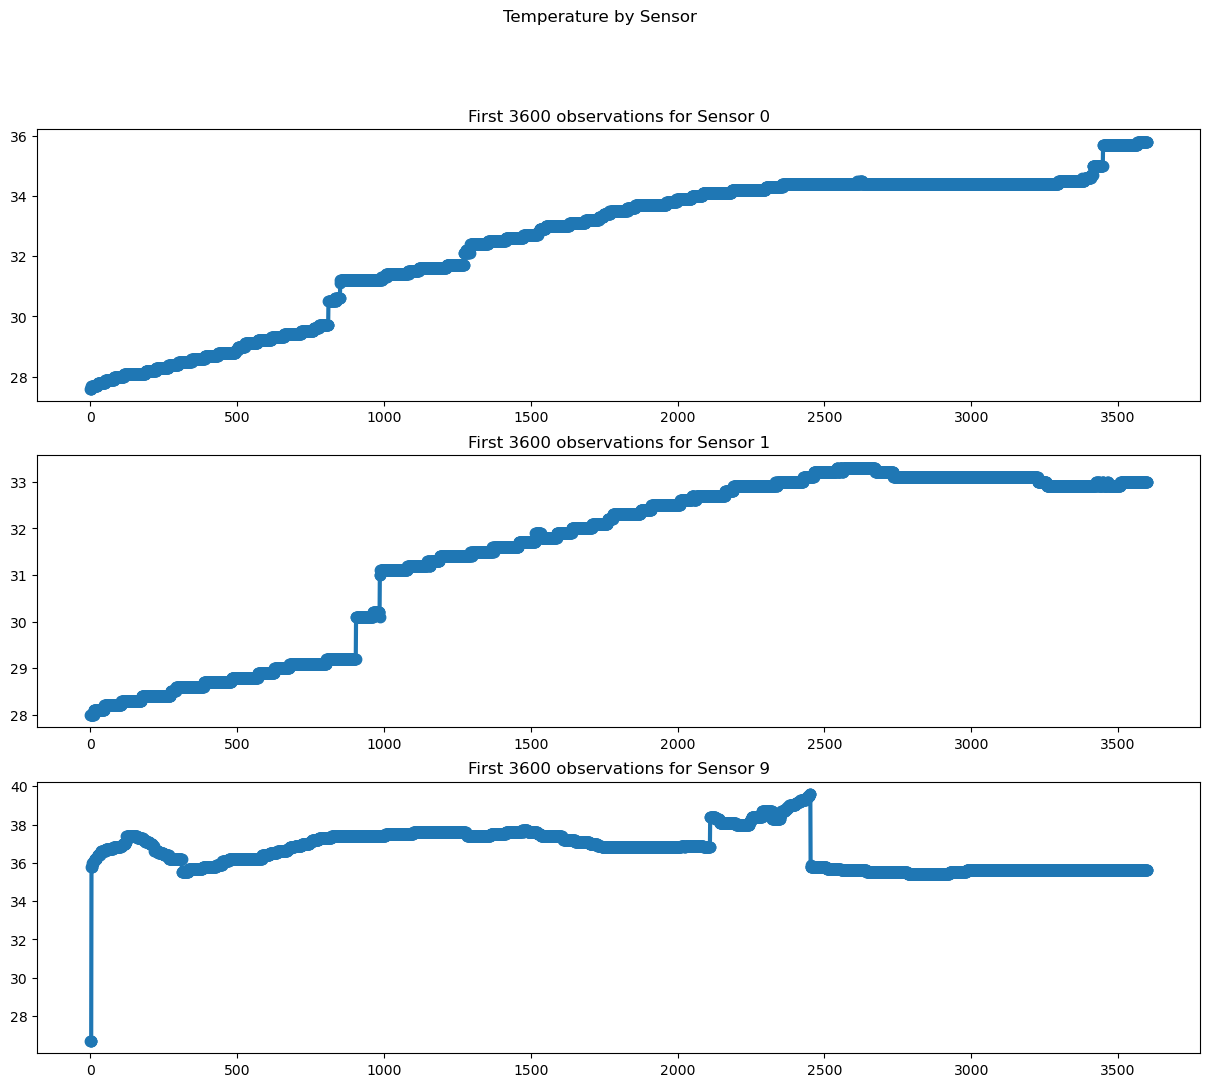

In [41]:
fig, axs_ = plt.subplots(3)
fig.set_figheight(12)
fig.set_figwidth(15)

for k in [0,1,9]:
    axs_[[0,1,9].index(k)].plot(range(n),data[data[6]==k].iloc[0:n,3], ".-", linewidth=3, markersize=15, label="x")
    axs_[[0,1,9].index(k)].set_title(f"First {n} observations for Sensor {k}")
    #plt.plot(range(n), np.full(n,300))
    #axs_[[0,1,9].index(k)].plot(range(n), np.full(n,300))

#plt.title("CO2 Concentration")
fig.suptitle("Temperature by Sensor")
plt.savefig("./plots/temp.png")
plt.show()

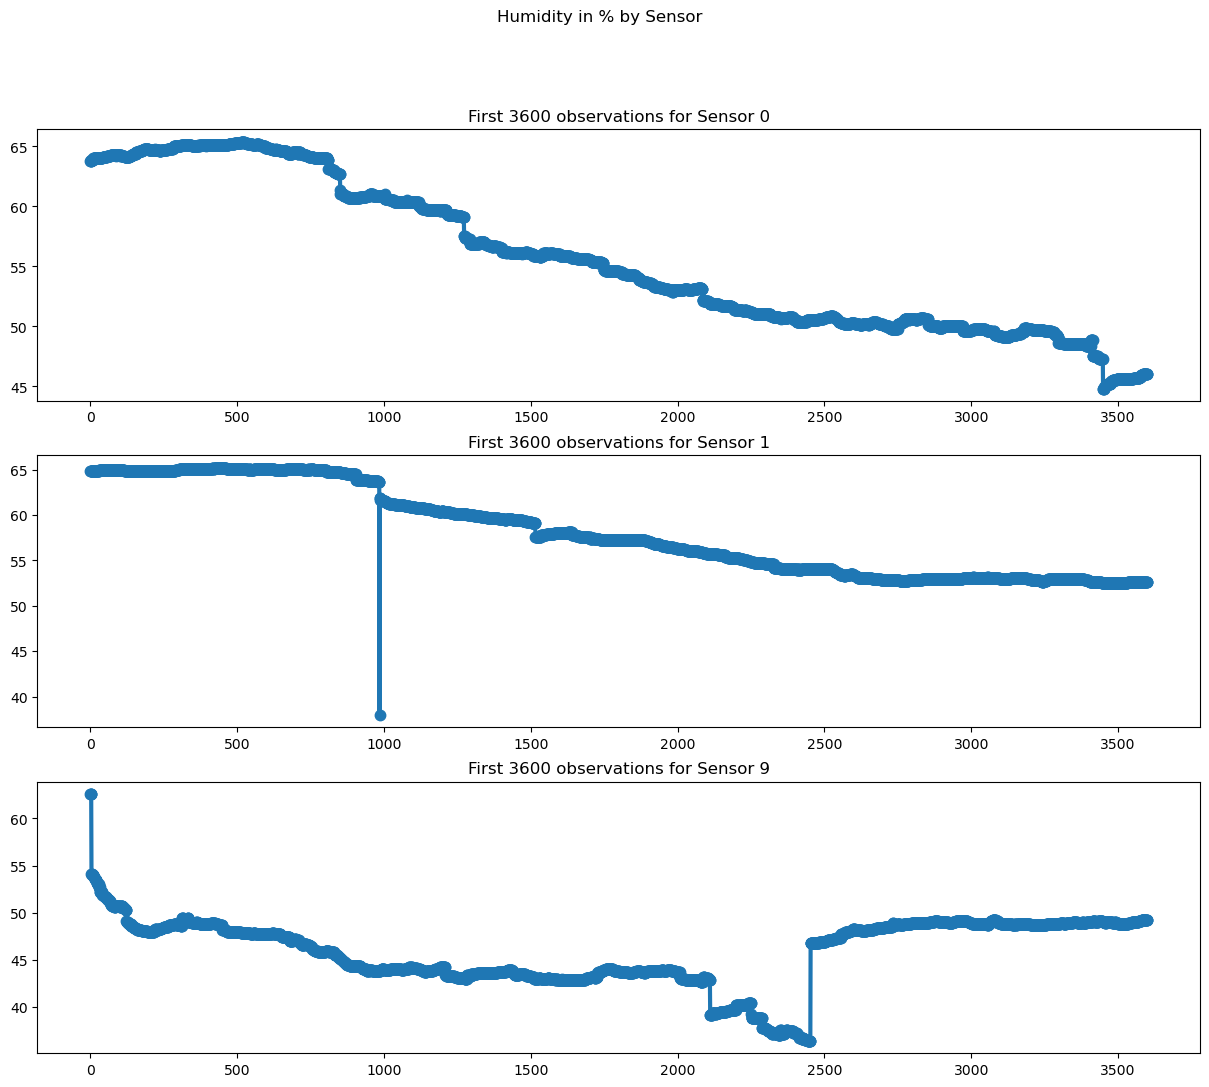

In [42]:
fig, axs_ = plt.subplots(3)
fig.set_figheight(12)
fig.set_figwidth(15)

for k in [0,1,9]:
    axs_[[0,1,9].index(k)].plot(range(n),data[data[6]==k].iloc[0:n,4], ".-", linewidth=3, markersize=15, label="x")
    axs_[[0,1,9].index(k)].set_title(f"First {n} observations for Sensor {k}")
    #plt.plot(range(n), np.full(n,300))
    #axs_[[0,1,9].index(k)].plot(range(n), np.full(n,300))

#plt.title("CO2 Concentration")
fig.suptitle("Humidity in % by Sensor")
plt.savefig("./plots/humidity.png")
plt.show()

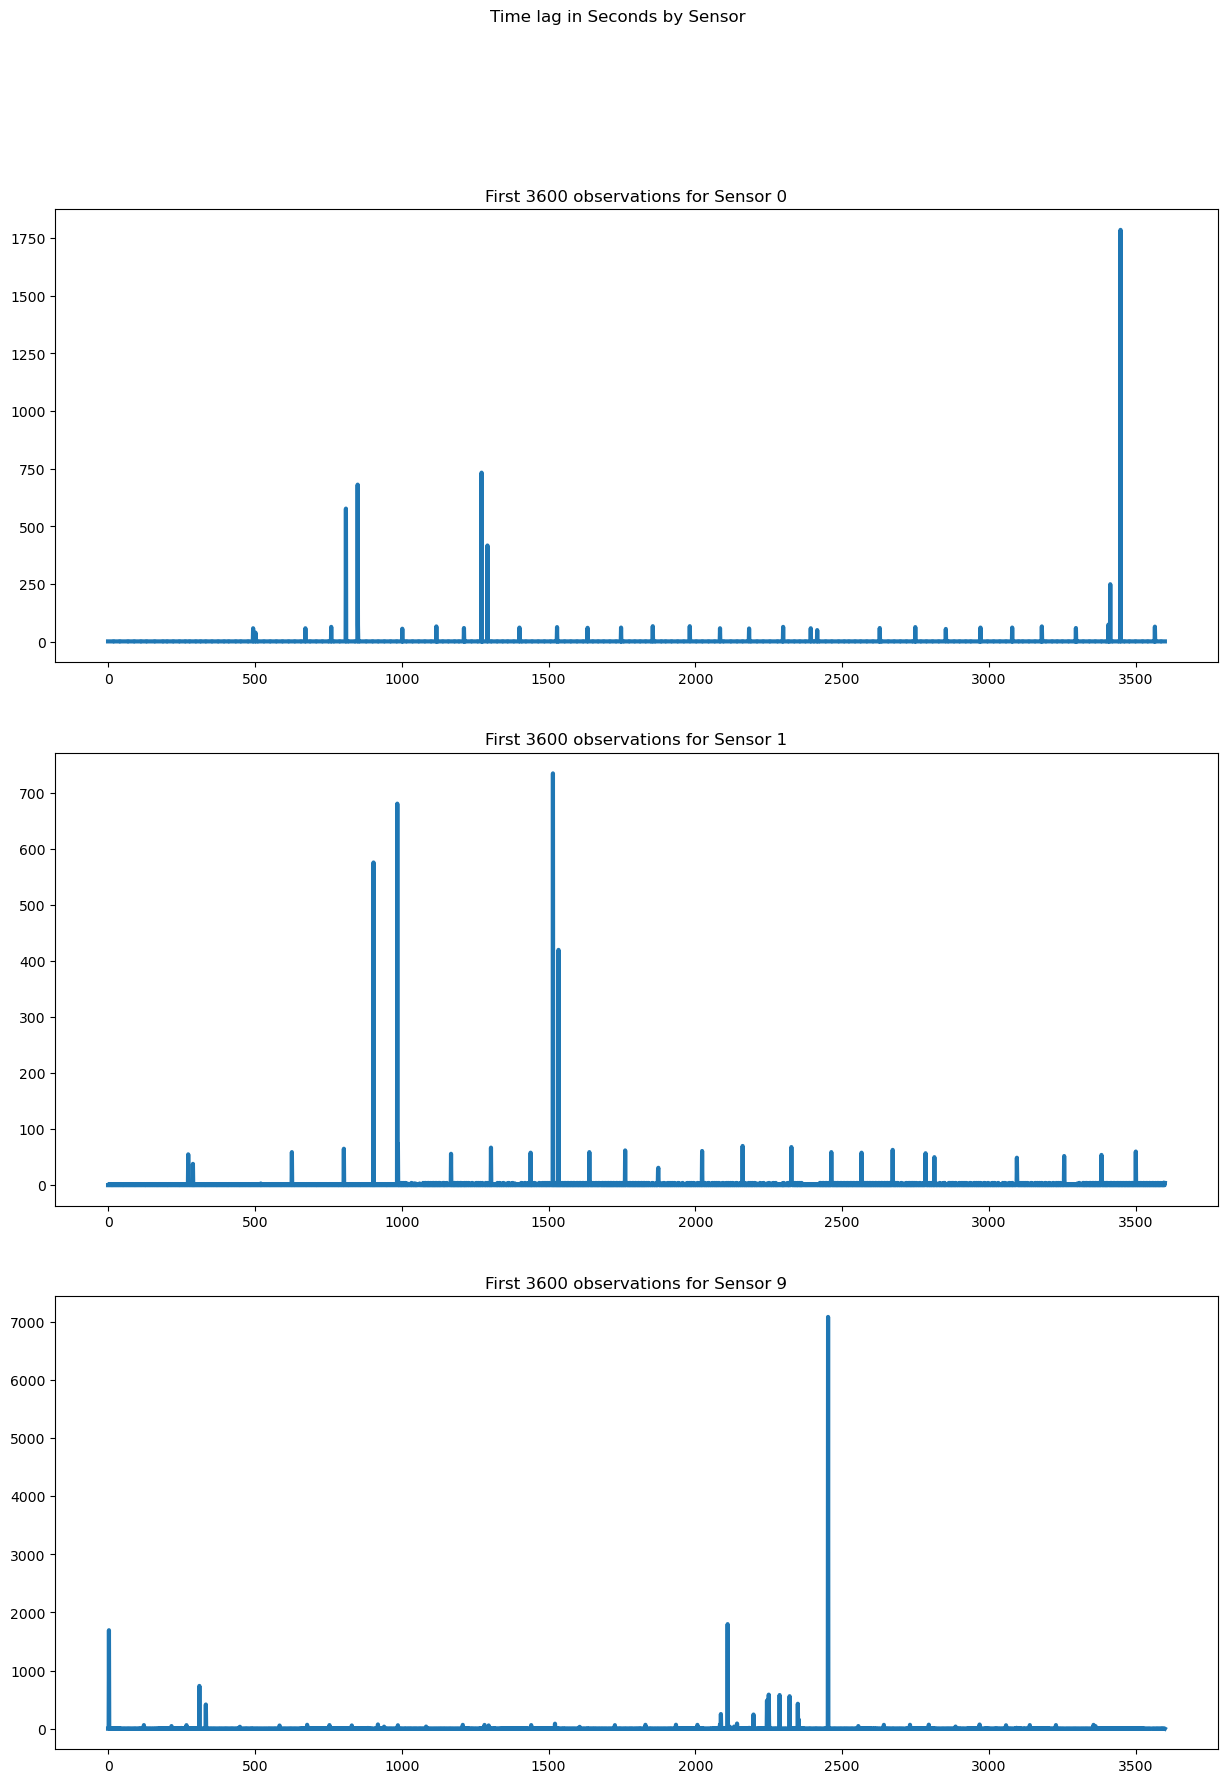

In [43]:
fig, axs_ = plt.subplots(3)
fig.set_figheight(20)
fig.set_figwidth(15)

for k in [0,1,9]:
    axs_[[0,1,9].index(k)].plot(range(n),np.diff(data[data[6]==k].iloc[0:n+1,1]), "-", linewidth=3, markersize=15, label="x")
    #plt.plot(range(n), np.full(n,300))
    axs_[[0,1,9].index(k)].set_title(f"First {n} observations for Sensor {k}")
    #axs_[[0,1,9].index(k)].plot(range(n), np.full(n,300))

#plt.title("CO2 Concentration")
fig.suptitle("Time lag in Seconds by Sensor")
plt.savefig("./plots/timelag.png")
#plt.show()

### Split the data per sensor for differencing

In [71]:
dataSensor0 = data[data[6] == 0]
dataSensor1 = data[data[6] == 1]
dataSensor9 = data[data[6] == 9]

In [72]:
print(dataSensor0.shape)
print(dataSensor1.shape)
print(dataSensor9.shape)

(2079142, 8)
(2214603, 8)
(1782993, 8)


C:\Users\paulw\AppData\Local\Temp\ipykernel_7976\2952620935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSensor0.loc[:,"timeLag"] = timelag0


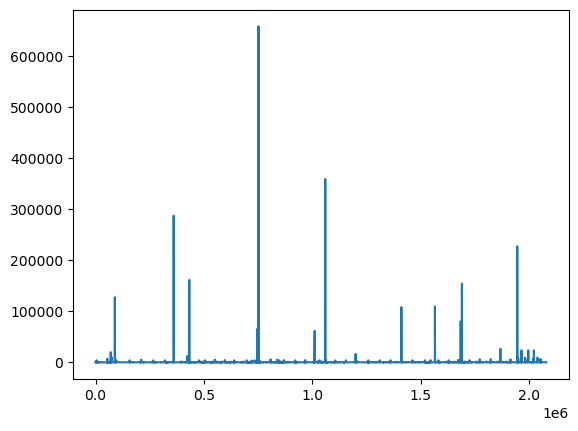

In [73]:
timelag0 = np.concatenate([[0],np.diff(dataSensor0[1].sort_values())], axis=0)
dataSensor0.loc[:,"timeLag"] = timelag0
plt.plot(np.diff(dataSensor0[1].sort_values()))

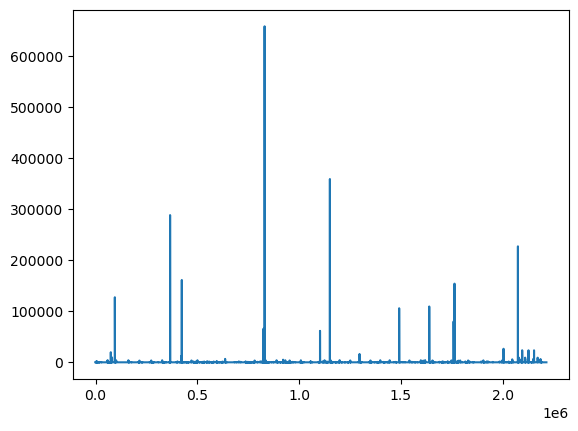

In [74]:
plt.plot(np.diff(dataSensor1[1].sort_values()))

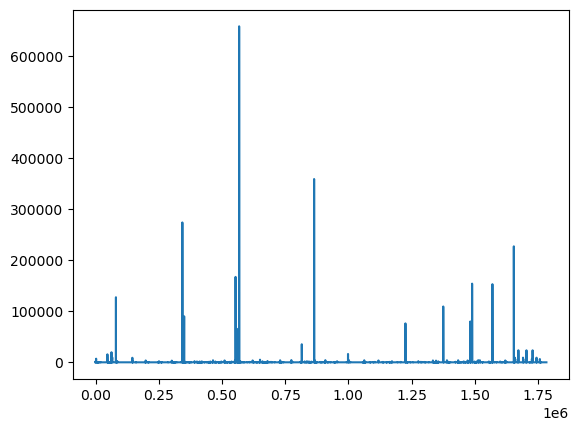

In [75]:
timelag9 = np.concatenate([[0],np.diff(dataSensor9[1])], axis=0)
plt.plot(np.diff(dataSensor9[1].sort_values()))

In [76]:
dataSensor9.loc[:,"timeLag"] = timelag9

C:\Users\paulw\AppData\Local\Temp\ipykernel_7976\584953380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSensor9.loc[:,"timeLag"] = timelag9


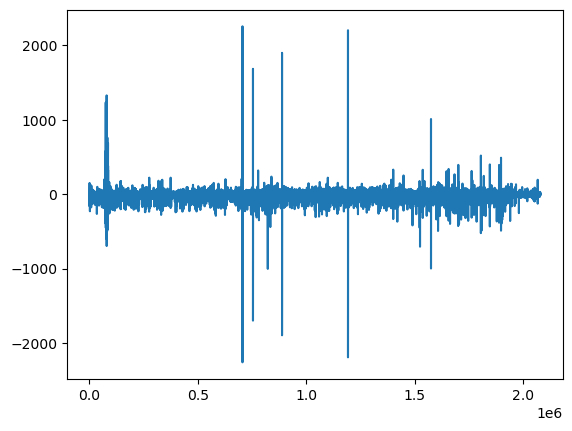

In [77]:
plt.plot(np.diff(dataSensor0.sort_values(by=0)[2]))

In [78]:
dataSensor0[dataSensor0["timeLag"] > 60]

,0,1,2,3,4,5,6,7,timeLag
1577,8269256.0,1533200762,264.0,29.600000,64.000000,28.0,0.0,2018-08-02 16:06:02,64
1730,8269409.0,1533201390,278.0,30.500000,63.099998,27.0,0.0,2018-08-02 16:16:30,577
1850,8269529.0,1533202112,253.0,31.100000,61.400002,29.0,0.0,2018-08-02 16:28:32,681
1853,8269532.0,1533202186,402.0,31.200001,61.000000,25.0,0.0,2018-08-02 16:29:46,74
2652,8270329.0,1533202584,269.0,31.600000,60.000000,29.0,0.0,2018-08-02 16:36:24,66
...,...,...,...,...,...,...,...,...,...
6068496,14341848.0,1539557470,264.0,28.299999,64.099998,583.0,0.0,2018-10-15 05:51:10,61
6069683,14343041.0,1539558115,278.0,28.200001,64.400002,583.0,0.0,2018-10-15 06:01:55,61
6069974,14343333.0,1539558275,285.0,28.200001,64.199997,144.0,0.0,2018-10-15 06:04:35,61
6070268,14343629.0,1539558436,310.0,28.200001,64.300003,145.0,0.0,2018-10-15 06:07:16,61


In [79]:
dataSensor0[dataSensor0["timeLag"] > 100000]

,0,1,2,3,4,5,6,7,timeLag
268818,8536667.0,1533549561,260.0,32.000000,47.299999,18.0,0.0,2018-08-06 16:59:21,127384
1081273,9349711.0,1534263332,187.0,28.400000,62.599998,26.0,0.0,2018-08-14 23:15:32,287045
1218048,9486540.0,1534526436,220.0,30.400000,54.500000,29.0,0.0,2018-08-18 00:20:36,161234
2180426,10449747.0,1535884989,203.0,34.400002,52.500000,14.0,0.0,2018-09-02 17:43:09,657915
3107611,11377828.0,1536923937,236.0,35.900002,40.099998,17.0,0.0,2018-09-14 18:18:57,358891
4161290,12432444.0,1537635066,292.0,28.500000,71.400002,41.0,0.0,2018-09-22 23:51:06,107906
4614122,12885753.0,1538027975,218.0,24.000000,79.400002,296.0,0.0,2018-09-27 12:59:35,109282
4980407,13252456.0,1538498002,182.0,32.599998,53.500000,40.0,0.0,2018-10-02 23:33:22,154025
5712584,13985554.0,1539192676,229.0,32.299999,33.500000,247.0,0.0,2018-10-11 00:31:16,227072


In [173]:
dataSensor0.columns.get_loc("co2Jumps")

10

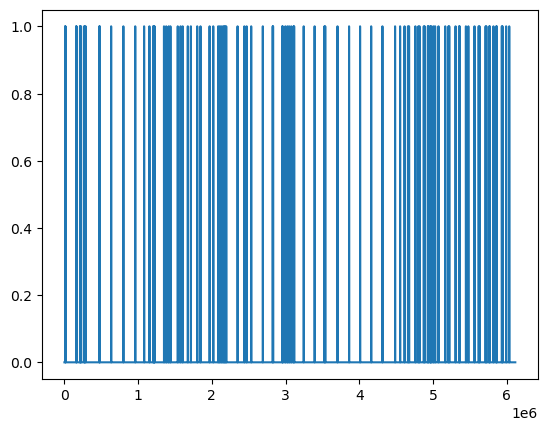

In [80]:
plt.plot(dataSensor0["timeLag"]>1000)

In [ ]:
co2Gradient0 = np.concatenate([np.diff(dataSensor0.sort_values(by=0)[2]),[0]], axis=0)
dataSensor0.iloc[:,10] = (pd.Series(np.abs(co2Gradient0)))

def isWeekend(dateInDTformat):
    return(dateInDTformat.weekday()>4)

weekendBM = dataSensor0.iloc[:,7].apply(lambda f: isWeekend(f))
breakdown = (weekendBM) & (dataSensor0["timeLag"]>1000)
dataSensor0["breakDown"] = breakdown.astype(int)


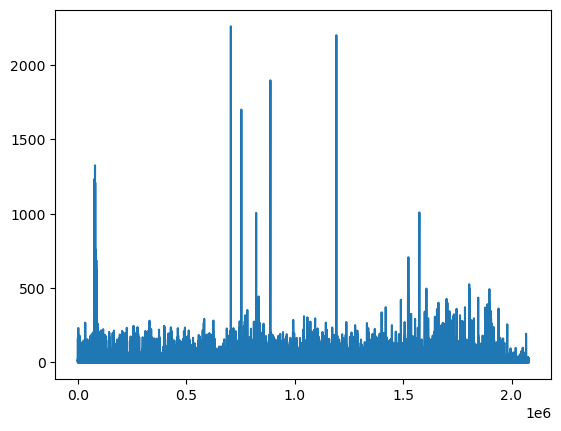

In [130]:
plt.plot(pd.Series(np.abs(co2Gradient0)))

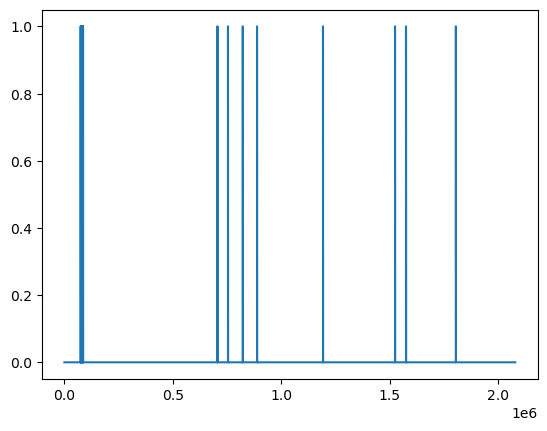

In [134]:
plt.plot(pd.Series(np.abs(co2Gradient0)) > 500)

In [ ]:
dataSensor0.iloc[:,10] = (pd.Series(np.abs(co2Gradient0)))

def isWeekend(dateInDTformat):
    return(dateInDTformat.weekday()>4)

weekendBM = dataSensor0.iloc[:,7].apply(lambda f: isWeekend(f))
breakdown = (weekendBM) & (dataSensor0["timeLag"]>1000)
dataSensor0["breakDown"] = breakdown.astype(int)


In [142]:
dataSensor0

,0,1,2,3,4,5,6,7,timeLag,breakDown,co2Jumps
3,8267681.0,1533199751,287.0,27.600000,63.799999,25.0,0.0,2018-08-02 15:49:11,0,0,9.0
4,8267682.0,1533199752,296.0,27.600000,63.799999,24.0,0.0,2018-08-02 15:49:12,1,0,5.0
5,8267683.0,1533199753,301.0,27.600000,63.799999,24.0,0.0,2018-08-02 15:49:13,1,0,4.0
6,8267684.0,1533199754,297.0,27.600000,63.799999,23.0,0.0,2018-08-02 15:49:14,1,0,18.0
7,8267685.0,1533199755,315.0,27.700001,63.900002,23.0,0.0,2018-08-02 15:49:15,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
6116469,14389944.0,1539576830,299.0,26.900000,66.599998,147.0,0.0,2018-10-15 11:13:50,1,0,11.0
6116472,14389947.0,1539576831,310.0,26.900000,66.599998,147.0,0.0,2018-10-15 11:13:51,1,0,9.0
6116474,14389950.0,1539576832,301.0,26.900000,66.599998,146.0,0.0,2018-10-15 11:13:52,1,0,5.0
6116475,14389953.0,1539576833,306.0,26.900000,66.599998,145.0,0.0,2018-10-15 11:13:53,1,0,6.0


In [92]:
def isWeekend(dateInDTformat):
    return(dateInDTformat.weekday()>4)

In [88]:
dataSensor0.iloc[0,7].weekday()

3

In [95]:
weekendBM = dataSensor0.iloc[:,7].apply(lambda f: isWeekend(f))

In [103]:
dataSensor0[(weekendBM) & (dataSensor0["timeLag"]>1000)]

,0,1,2,3,4,5,6,7,timeLag
211808,8479627.0,1533378568,260.0,30.900000,48.799999,28.0,0.0,2018-08-04 17:29:28,19743
213510,8481329.0,1533382191,222.0,33.400002,43.599998,30.0,0.0,2018-08-04 18:29:51,1583
225984,8493808.0,1533398550,170.0,32.799999,47.700001,27.0,0.0,2018-08-04 23:02:30,9515
1218048,9486540.0,1534526436,220.0,30.400000,54.500000,29.0,0.0,2018-08-18 00:20:36,161234
1222565,9491061.0,1534530584,93.0,29.500000,57.799999,574.0,0.0,2018-08-18 01:29:44,1126
1222597,9491093.0,1534532373,248.0,29.500000,58.200001,583.0,0.0,2018-08-18 01:59:33,1780
1350848,9619443.0,1534602592,74.0,34.200001,50.599998,21.0,0.0,2018-08-18 21:29:52,3980
1380957,9649583.0,1534618774,74.0,28.900000,60.500000,585.0,0.0,2018-08-19 01:59:34,1607
1414663,9683360.0,1534661977,281.0,23.700001,67.699997,36.0,0.0,2018-08-19 13:59:37,1591
1438185,9706884.0,1534689006,176.0,36.599998,38.900002,22.0,0.0,2018-08-19 21:30:06,3993


In [ ]:
def isWeekend(dateInDTformat):
    return(dateInDTformat.weekday()>4)

weekendBM = dataSensor0.iloc[:,7].apply(lambda f: isWeekend(f))
breakdown = (weekendBM) & (dataSensor0["timeLag"]>1000)
dataSensor0["breakDown"] = breakdown.astype(int)


In [115]:
dataSensor0["breakDown"] = breakdown.astype(int)

C:\Users\paulw\AppData\Local\Temp\ipykernel_7976\1257364875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSensor0["breakDown"] = breakdown.astype(int)


Still to do:
- take difference in signals for gradient
- split data per sensor

## Creating some STL formulae

- Easy option: Create threshholds -> value never exceeds a certain value (most should be okay after cleaning)

##### Whenever Humidity below x -> Co2 below  

In [167]:
c = torch.tensor(.99, dtype=torch.float, requires_grad=False)
d = torch.tensor(500.0, dtype=torch.float, requires_grad=False)

ϕBreak = stlcg.GreaterThan(lhs='x', val=c)
ϕCo2 = stlcg.GreaterThan(lhs='g', val=d)
#ϕ3 = stlcg.LessThan(lhs='w', val=d)
#ϕ = stlcg.Always(subformula=ϕ1)
#ψ = stlcg.Eventually(subformula=ϕ3)
#formula = stlcg.Implies(subformula1=ϕBreak, subformula2=stlcg.Eventually(ϕCo2, interval=[0,60]))
formula = stlcg.Implies(subformula1=ϕCo2, subformula2=stlcg.Eventually(ϕBreak, interval=[0,1]))
#formula = stlcg.Implies(subformula1=ϕHum, subformula2=ϕCo2)
#ftest = stlcg.Always(subformula=formula, interval=[0,60])
print(formula)
#viz.make_stl_graph(formula).render("./plots/formulae/stlFormulaResponse", format="png")
graph = viz.make_stl_graph(formula)
viz.save_graph(graph, "./plots/formulae/stlFormulaResponseDiscrete")


(g >= input) => (♢ [0, 1]( x >= input ))


---------------------------------------------------

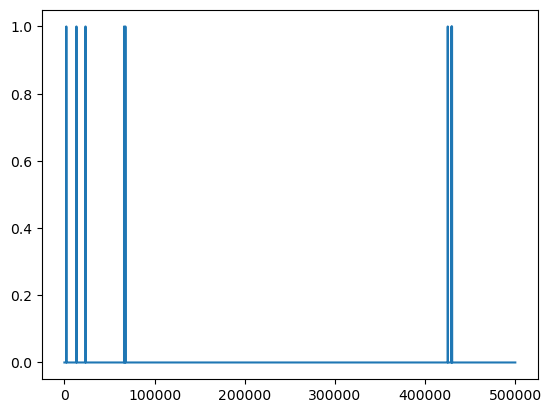

In [169]:
plt.plot(ϕBreak.eval_trace((breakTensor0)).detach().numpy().reshape(1,n).squeeze())

In [153]:
#n=dataSensor0.shape[0] # running on the entire data set (only for one sensor) already kills my memory :(
#n = 60
n = 500000
#n=60*60*24 # running the data on one day seems to still work decently fine (first run took 18s)
#n = 60*60*24*7 #not enough entries for 30 days
#n = 60*60*24*10

In [154]:
co2Sens0 = np.array(dataSensor0.iloc[0:(n),10]).reshape([1, n, 1])
#humSens0 = np.array(dataSensor0.iloc[0:(n),4]).reshape([1, n, 1])
breakSens0 = np.array(dataSensor0.iloc[0:(n),9]).reshape([1, n, 1])
co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
breakTensor0 = torch.tensor(breakSens0, requires_grad=False, dtype=torch.float).flip(1)
#humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)

In [ ]:
"""co2Sens0 = np.array(dataSensor0.iloc[0:(n),2]).reshape([1, n, 1])
#humSens0 = np.array(dataSensor0.iloc[0:(n),4]).reshape([1, n, 1])
co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
#humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)"""

In [155]:
breakSens0

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

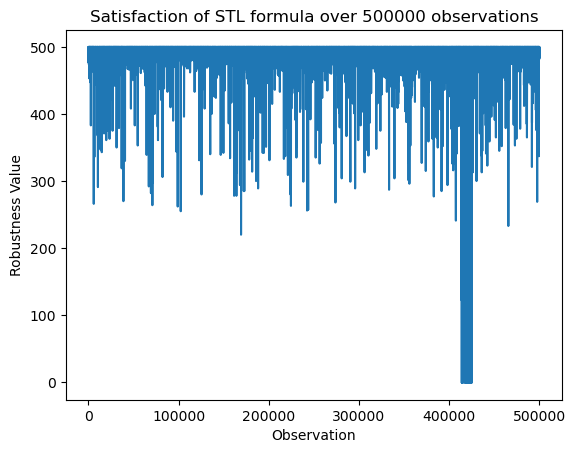

In [170]:
inputs = (co2Tensor0, breakTensor0)
pscale = 1     # "pscale" is the scale used for evaluting predicates
scale = -1
plt.plot(formula.robustness_trace(inputs, pscale=pscale, scale=scale).detach().numpy().reshape(1,n).squeeze())
plt.xlabel("Observation")
plt.ylabel("Robustness Value")
plt.title(f"Satisfaction of STL formula over {n} observations")
plt.savefig("./experiments/robustness/plot1.png")
plt.show()

In [ ]:
#co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
#humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)

#c = torch.tensor(0.0, dtype=torch.float, requires_grad=True)
#c = torch.tensor(0.0, dtype=torch.float, requires_grad=True)

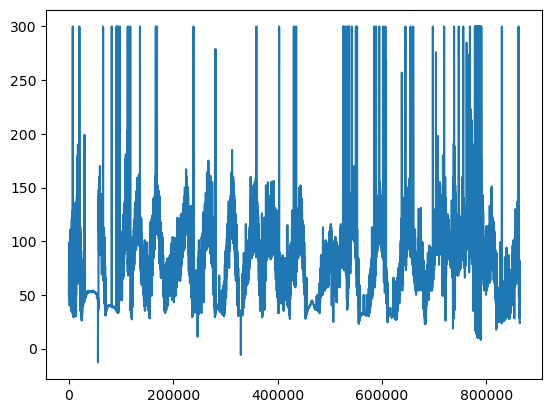

In [ ]:
# any of the inputs will work
#inputs = (humTensor0, co2Tensor0)
# inputs = (w_exp, (x_exp, w_exp))
# inputs = (w, (x, w))

#pscale = 1     # "pscale" is the scale used for evaluting predicates
#scale = -1     # "scale" is the scale used in the maxish/minish function. <0 defaults to the true min/max
#ϕ(inputs, pscale=pscale, scale=scale)

#plt.plot(formula.robustness_trace(inputs, pscale=pscale, scale=scale).detach().numpy().reshape(1,n).squeeze())
#plt.plot(ϕ11.robustness_trace(xtorch).detach().numpy().reshape(1,140).squeeze())

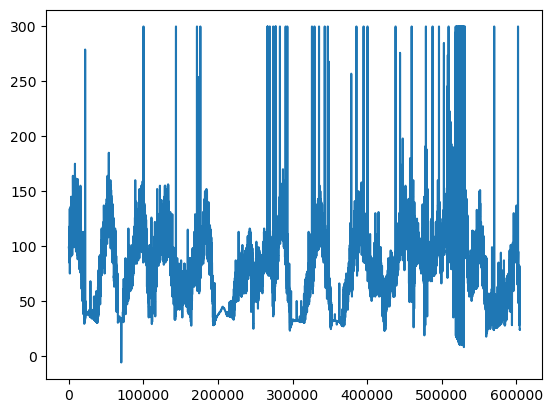

In [ ]:
# any of the inputs will work
#inputs = (humTensor0, co2Tensor0)
# inputs = (w_exp, (x_exp, w_exp))
# inputs = (w, (x, w))

#pscale = 1     # "pscale" is the scale used for evaluting predicates
#scale = -1     # "scale" is the scale used in the maxish/minish function. <0 defaults to the true min/max
#ϕ(inputs, pscale=pscale, scale=scale)

#plt.plot(formula.robustness_trace(inputs, pscale=pscale, scale=scale).detach().numpy().reshape(1,n).squeeze())
#plt.plot(ϕ11.robustness_trace(xtorch).detach().numpy().reshape(1,140).squeeze())

In [ ]:
#inputs = (humTensor0, co2Tensor0)
#pscale = 1     # "pscale" is the scale used for evaluting predicates
#scale = -1

In [ ]:
#n_experiments = 10

In [ ]:
#r = timeit.repeat(lambda:formula.robustness_trace(inputs, pscale=pscale, scale=scale), number=n_experiments)

In [ ]:
#rScaled = np.divide(r,n_experiments)

In [ ]:
#if os.path.isdir("./experiments"):
#    #if os.path.isfile("./experiments/results.csv"):
#    with open("./experiments/results.csv", "a") as f:
#        f.write(f"{rScaled.mean()};{rScaled.std()};{n_experiments};{n};{rScaled.mean()/n}")


In [ ]:
#if os.path.isdir("./experiments"):
#    #if os.path.isfile("./experiments/results.csv"):
#        with open("./experiments/results.csv", "a") as f:
#            f.write(f"{rScaled.mean()};{{rScaled.std()}};{n_experiments};{n};{rScaled.mean()/n}")
#else: os.mkdir("./experiments")


In [ ]:
#print(f"Average Duration: \t {rScaled.mean()} +- {rScaled.std()}")
#print(f"Duration scaled  \t {rScaled.mean()/n}")

Average Duration: 	 0.6732683400000007 +- 0.029247660269279756.%2f
Duration scaled  	 0.00018701898333333352


In [ ]:
#np.mean([r1/10 for r1 in r])

0.7713321240001824

### Making some tests

In [82]:
n_obs = [60, 60*60, 60*60*24, 60*60*24*2, 60*60*24*3, 60*60*24*5, 60*60*24*7, 60*60*24*10]
#n_obs = [60, 60*60, 60*60*24, 60*60*24*2, 60*60*24*3, 60*60*24*5, 60*60*24*7]

TypeError: 'str' object is not callable

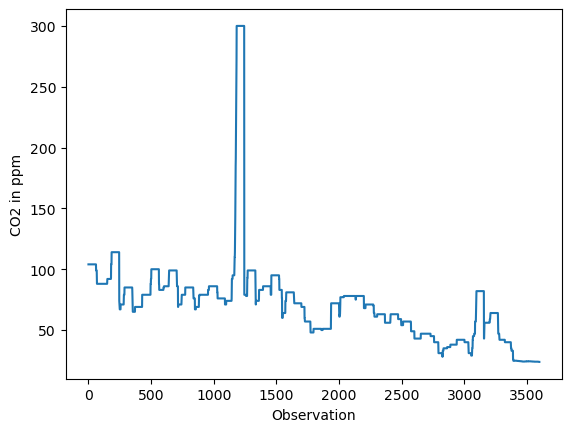

In [ ]:
nobs = 3600
co2Sens0 = np.array(dataSensor0.iloc[0:(nobs),2]).reshape([1, nobs, 1])
humSens0 = np.array(dataSensor0.iloc[0:(nobs),4]).reshape([1, nobs, 1])
co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)
inputs = (humTensor0, co2Tensor0)
pscale = 1     # "pscale" is the scale used for evaluting predicates
scale = -1
plt.plot(formula.robustness_trace(inputs, pscale=pscale, scale=scale).detach().numpy().reshape(1,nobs).squeeze())
plt.xlabel("Observation")
plt.ylabel("Robustness Value")
plt.title(f"Satisfaction of STL formula over {nobs} observations")
plt.savefig("./experiments/robustness/plot1.png")
plt.show()

In [ ]:
#n_experiments = 10
# The runtime becomes quite long if I do 10*5 iterations of the same experiment (at roughly 20 minutes that becomes easily around 16+ hours for one experiment)
n_experiments = 1

In [ ]:
for nobs in n_obs:
    co2Sens0 = np.array(dataSensor0.iloc[0:(nobs),2]).reshape([1, nobs, 1])
    humSens0 = np.array(dataSensor0.iloc[0:(nobs),4]).reshape([1, nobs, 1])
    co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
    humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)
    inputs = (humTensor0, co2Tensor0)
    pscale = 1     # "pscale" is the scale used for evaluting predicates
    scale = -1
    plt.plot(formula.robustness_trace(inputs, pscale=pscale, scale=scale).detach().numpy().reshape(1,nobs).squeeze())
    plt.xlabel("Number of Observation")
    plt.ylabel("CO2 in ppm")
    plt.title(f"Satisfaction of STL formula over {nobs} observations")
    plt.savefig("./experiments/robustness/plot1.png")
    r = timeit.repeat(lambda:formula.robustness_trace(inputs, pscale=pscale, scale=scale), number=n_experiments)
    rScaled = np.divide(r,n_experiments)
    if os.path.isdir("./experiments"):
    #if os.path.isfile("./experiments/results.csv"):
        with open("./experiments/results.csv", "a") as f:
            f.write(f"{rScaled};{rScaled.mean()};{rScaled.std()};{n_experiments};{nobs};{rScaled.mean()/nobs}\n")

KeyboardInterrupt: 

### Simple formula test

In [76]:
def runExperiments(data, formula, numberOfExperiments, numberOfIterations):
    return True

◻ [0, inf]( x <= 1000.0 )


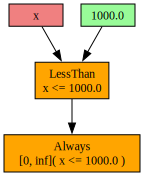

In [77]:
#c = torch.tensor(40.0, dtype=torch.float, requires_grad=True)
u = torch.tensor(1000.0, dtype=torch.float, requires_grad=True)

#ϕHum = stlcg.LessThan(lhs='x', val=c)
ϕCo2 = stlcg.LessThan(lhs='x', val=u)

#formula = stlcg.Implies(subformula1=ϕHum, subformula2=stlcg.Eventually(stlcg.Always(ϕCo2, interval=[0,10]), interval=[0,60]))
formula = stlcg.Always(subformula=ϕCo2)
#ftest = stlcg.Always(subformula=formula, interval=[0,60])
print(formula)
viz.make_stl_graph(formula)
#print(ϕ)

In [ ]:
#n_obs = [60*60*24*7]
#n_experiments=1

In [83]:
for nobs in n_obs:
    co2Sens0 = np.array(dataSensor0.iloc[0:(nobs),2]).reshape([1, nobs, 1])
    #humSens0 = np.array(dataSensor0.iloc[0:(nobs),4]).reshape([1, nobs, 1])
    co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
    #humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)
    inputs = (co2Tensor0)
    pscale = 1     # "pscale" is the scale used for evaluting predicates
    scale = -1
    r = timeit.repeat(lambda:formula.robustness_trace(inputs, pscale=pscale, scale=scale), number=n_experiments)
    rScaled = np.divide(r,n_experiments)
    if os.path.isdir("./experiments"):
    #if os.path.isfile("./experiments/results.csv"):
        with open("./experiments/resultsSimple.csv", "a") as f:
            f.write(f"{rScaled};{rScaled.mean()};{rScaled.std()};{n_experiments};{nobs};{rScaled.mean()/nobs}\n")

----------------------------------------------------

◻ [0, inf]( (x <= 1000.0) ∧ (x >= 150.0) )


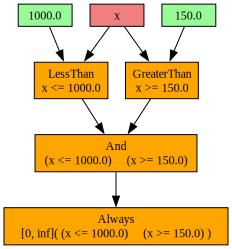

In [84]:
#c = torch.tensor(40.0, dtype=torch.float, requires_grad=True)
u = torch.tensor(1000.0, dtype=torch.float, requires_grad=True)
lower =  torch.tensor(150.0, dtype=torch.float, requires_grad=True)

#ϕHum = stlcg.LessThan(lhs='x', val=c)
ϕCo2 = stlcg.LessThan(lhs='x', val=u)
ϕCo2low = stlcg.GreaterThan(lhs='x', val=lower)

#formula = stlcg.Implies(subformula1=ϕHum, subformula2=stlcg.Eventually(stlcg.Always(ϕCo2, interval=[0,10]), interval=[0,60]))
formula = stlcg.Always(subformula=stlcg.And(ϕCo2, ϕCo2low))
#ftest = stlcg.Always(subformula=formula, interval=[0,60])
print(formula)
viz.make_stl_graph(formula)
#print(ϕ)

In [86]:
for nobs in n_obs:
    co2Sens0 = np.array(dataSensor0.iloc[0:(nobs),2]).reshape([1, nobs, 1])
    #humSens0 = np.array(dataSensor0.iloc[0:(nobs),4]).reshape([1, nobs, 1])
    co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
    #humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)
    inputs = (co2Tensor0,co2Tensor0)
    pscale = 1     # "pscale" is the scale used for evaluting predicates
    scale = -1
    r = timeit.repeat(lambda:formula.robustness_trace(inputs, pscale=pscale, scale=scale), number=n_experiments)
    rScaled = np.divide(r,n_experiments)
    if os.path.isdir("./experiments"):
    #if os.path.isfile("./experiments/results.csv"):
        with open("./experiments/resultsSimpleTwo.csv", "a") as f:
            f.write(f"{rScaled};{rScaled.mean()};{rScaled.std()};{n_experiments};{nobs};{rScaled.mean()/nobs}\n")

------------------------------------------------------------------

(◻ [0, inf]( (x <= 1000.0) ∧ (x >= 150.0) )) ∧ (◻ [0, inf]( t <= 40.0 ))


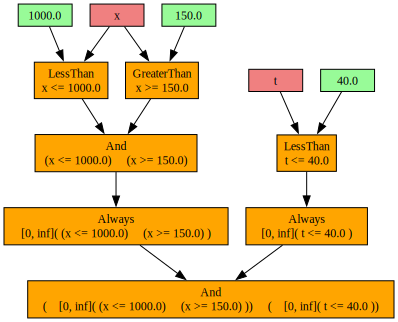

In [90]:
#c = torch.tensor(40.0, dtype=torch.float, requires_grad=True)
u = torch.tensor(1000.0, dtype=torch.float, requires_grad=True)
lower =  torch.tensor(150.0, dtype=torch.float, requires_grad=True)
tUp = torch.tensor(40.0, dtype=torch.float, requires_grad=True)

#ϕHum = stlcg.LessThan(lhs='x', val=c)
ϕCo2 = stlcg.LessThan(lhs='x', val=u)
ϕCo2low = stlcg.GreaterThan(lhs='x', val=lower)
ϕtempUp = stlcg.Always(stlcg.LessThan(lhs='t', val=tUp))


f1 = stlcg.Always(subformula=stlcg.And(ϕCo2, ϕCo2low))
formula = stlcg.And(subformula1 = f1, subformula2 = ϕtempUp)
print(formula)
viz.make_stl_graph(formula)

In [91]:
dataSensor0

,0,1,2,3,4,5,6,7
3,8267681.0,1533199751,287.0,27.600000,63.799999,25.0,0.0,02-08-2018 15:49:11
4,8267682.0,1533199752,296.0,27.600000,63.799999,24.0,0.0,02-08-2018 15:49:12
5,8267683.0,1533199753,301.0,27.600000,63.799999,24.0,0.0,02-08-2018 15:49:13
6,8267684.0,1533199754,297.0,27.600000,63.799999,23.0,0.0,02-08-2018 15:49:14
7,8267685.0,1533199755,315.0,27.700001,63.900002,23.0,0.0,02-08-2018 15:49:15
...,...,...,...,...,...,...,...,...
6116469,14389944.0,1539576830,299.0,26.900000,66.599998,147.0,0.0,15-10-2018 11:13:50
6116472,14389947.0,1539576831,310.0,26.900000,66.599998,147.0,0.0,15-10-2018 11:13:51
6116474,14389950.0,1539576832,301.0,26.900000,66.599998,146.0,0.0,15-10-2018 11:13:52
6116475,14389953.0,1539576833,306.0,26.900000,66.599998,145.0,0.0,15-10-2018 11:13:53


In [92]:
for nobs in n_obs:
    co2Sens0 = np.array(dataSensor0.iloc[0:(nobs),2]).reshape([1, nobs, 1])
    #humSens0 = np.array(dataSensor0.iloc[0:(nobs),4]).reshape([1, nobs, 1])
    tempSens0 = np.array(dataSensor0.iloc[0:(nobs),3]).reshape([1, nobs, 1])
    co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
    tempTensor0 = torch.tensor(tempSens0, requires_grad=False, dtype=torch.float).flip(1)
    
    #humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)
    inputs = ((co2Tensor0,co2Tensor0), tempTensor0)
    pscale = 1     # "pscale" is the scale used for evaluting predicates
    scale = -1
    r = timeit.repeat(lambda:formula.robustness_trace(inputs, pscale=pscale, scale=scale), number=n_experiments)
    rScaled = np.divide(r,n_experiments)
    if os.path.isdir("./experiments"):
    #if os.path.isfile("./experiments/results.csv"):
        with open("./experiments/resultsSimpleThree.csv", "a") as f:
            f.write(f"{rScaled};{rScaled.mean()};{rScaled.std()};{n_experiments};{nobs};{rScaled.mean()/nobs}\n")

----------------------------------------------------

((◻ [0, inf]( (x <= 1000.0) ∧ (x >= 150.0) )) ∧ (◻ [0, inf]( t <= 40.0 ))) ∧ (◻ [0, inf]( h >= 0.0 ))


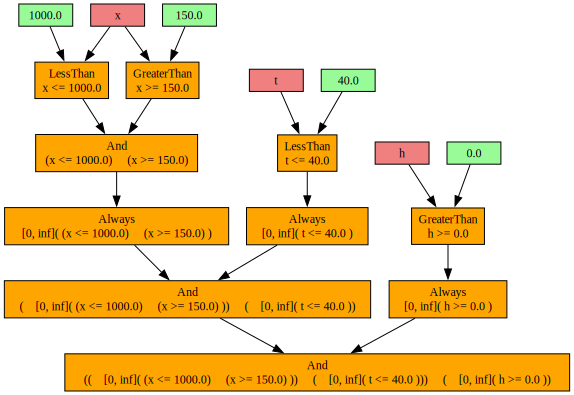

In [93]:
#c = torch.tensor(40.0, dtype=torch.float, requires_grad=True)
u = torch.tensor(1000.0, dtype=torch.float, requires_grad=True)
lower =  torch.tensor(150.0, dtype=torch.float, requires_grad=True)
tUp = torch.tensor(40.0, dtype=torch.float, requires_grad=True)
humLow = torch.tensor(0.0, dtype=torch.float, requires_grad=True)

#ϕHum = stlcg.LessThan(lhs='x', val=c)
ϕCo2 = stlcg.LessThan(lhs='x', val=u)
ϕCo2low = stlcg.GreaterThan(lhs='x', val=lower)
ϕtempUp = stlcg.Always(stlcg.LessThan(lhs='t', val=tUp))
ϕhumLow = stlcg.Always(stlcg.GreaterThan(lhs='h', val=humLow))


f1 = stlcg.Always(subformula=stlcg.And(ϕCo2, ϕCo2low))
formula = stlcg.And(stlcg.And(subformula1 = f1, subformula2 = ϕtempUp), ϕhumLow)
print(formula)
viz.make_stl_graph(formula)

In [94]:
for nobs in n_obs:
    co2Sens0 = np.array(dataSensor0.iloc[0:(nobs),2]).reshape([1, nobs, 1])
    humSens0 = np.array(dataSensor0.iloc[0:(nobs),4]).reshape([1, nobs, 1])
    tempSens0 = np.array(dataSensor0.iloc[0:(nobs),3]).reshape([1, nobs, 1])
    co2Tensor0 = torch.tensor(co2Sens0, requires_grad=False, dtype=torch.float).flip(1)
    tempTensor0 = torch.tensor(tempSens0, requires_grad=False, dtype=torch.float).flip(1)
    
    humTensor0 = torch.tensor(humSens0, requires_grad=False, dtype=torch.float).flip(1)
    inputs = (((co2Tensor0,co2Tensor0), tempTensor0), humTensor0)
    pscale = 1     # "pscale" is the scale used for evaluting predicates
    scale = -1
    r = timeit.repeat(lambda:formula.robustness_trace(inputs, pscale=pscale, scale=scale), number=n_experiments)
    rScaled = np.divide(r,n_experiments)
    if os.path.isdir("./experiments"):
    #if os.path.isfile("./experiments/results.csv"):
        with open("./experiments/resultsSimpleFour.csv", "a") as f:
            f.write(f"{rScaled};{rScaled.mean()};{rScaled.std()};{n_experiments};{nobs};{rScaled.mean()/nobs}\n")

-----------------------------------------------------------

#####################################################

To-do:
- discretize some values
    - Time of day / weekend
    - time lag greater than x
    - spike in light intensity
    - spike in temp
- clean up code
- (optional) create a Docker container to run everything on HPC
- More constraints to test (multiple input signals, different complexity, nesting of operators)